In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal 


# Data downloaded from:
# https://drive.google.com/drive/folders/0B6paC2__-QYFNEt6VnZ0QVlkYlk?resourcekey=0-VkKc0MOwfa8zGTkrCJ4bzA
# Linked from https://spikeforest.flatironinstitute.org/studyset/PAIRED_KAMPFF

### The code below has been adapted from:
# https://github.com/georgedimitriadis/themeaningofbrain/
# (see usage in https://github.com/georgedimitriadis/themeaningofbrain/blob/master/ExperimentSpecificCode/_2015_Paired_Recordings_JN/Joana_Neto/

def split_list_pairwise(l,p):
    groups = []
    prev = None
    group = None
    for x in l:
        if prev is None or p(x,prev):
            group = []
            groups.append(group)
        group.append(x)
        prev = x
    return groups


def custom_find_peaks(data_raw_spikes, threshold, inter_spike_time_distance=30, amp_gain=100,
                                  sampling_freq=30000, amp_y_digitization=65536, amp_y_range=10):

    scaling_factor = amp_y_range / (amp_y_digitization * amp_gain)
    data_in_v = (data_raw_spikes - np.mean(data_raw_spikes)) * scaling_factor

    derivative = np.diff(np.sign(np.diff(data_in_v))) #check when deriv changes sign
    if threshold > 0:
        derivative = derivative < 0
    else:
        derivative = derivative > 0

    peaks = np.flatnonzero(derivative) + 1  # local max
    if threshold > 0:
        peaks = peaks[data_in_v[peaks] > threshold]
    else:
        peaks = peaks[data_in_v[peaks] < threshold]

    if inter_spike_time_distance > 0:
        gpeaks = split_list_pairwise(peaks, lambda x, p: x - p > inter_spike_time_distance)
        peaks = np.array([g[np.argmax([data_in_v[i] for i in g])] for g in gpeaks])
    return peaks, data_in_v

In [4]:
data_folder = '2014_11_25_Pair_3_0'
Sampling_frequency = 30_000  #Hz
Probe_numChannels = 32
Probe_dtype = np.uint16
Probe_voltage_step_size = 0.195e-6
Probe_y_digitization = 32768
Juxta_numChannels = 8
Juxta_dtype = np.uint16
Juxta_ADC_used_channel = 0
Juxta_Gain = 100
Juxta_y_digitization = 65536
Juxta_y_range = 10
distance_min = 31 #(µm) 
Probe_closest_electrode = 23


# Load data from bin files into a matrix of n channels x m samples 
def loadRawData(filename, numChannels, dtype):
    
    fdata = np.fromfile(filename,dtype=dtype)
    assert len(fdata) % numChannels == 0
    numsamples = len(fdata) // numChannels
    data = np.reshape(fdata,(numsamples, numChannels))
    
    return np.transpose(data)


In [5]:
# Open ADC file 
# (juxtacellular recording from the juxtacellular micropipette -- frequency band from 300 to 7500 Hz)

filename = f"{data_folder}/adc2014-11-25T23_00_08.bin"
juxta_threshold = 0.8e-3 # from DataSummary.xlsx, converted to Volts
inter_spike_time_distance = 30 # (30 samples = 1 ms)

juxta = loadRawData(filename, numChannels = Juxta_numChannels, dtype = Juxta_dtype)
# the rescaling below (from 2014_11_13_Pair_1_0_Software.docx) looks wrong! 
# juxta_channel_Volts = juxta [Juxta_ADC_used_channel, :] * (Juxta_y_range /( Juxta_y_digitization * Juxta_Gain))
# based on the code for the IO.ephys.find_peaks function, must substract the mean first in order to use the threshold
# value provided in DataSummary.xlsx


# Generate the spike time triggers (and the adc traces in Volts) for the cell recorded juxta cellularly

spike_triggers, spike_data_in_V = custom_find_peaks(juxta[Juxta_ADC_used_channel],
                                                    threshold=juxta_threshold,
                                                    inter_spike_time_distance=inter_spike_time_distance,
                                                    amp_gain=Juxta_Gain,
                                                    amp_y_range=Juxta_y_range)

num_of_spikes = len(spike_triggers)
num_of_spikes

348

In [ ]:
spike_triggers[:10]

In [ ]:
### Plot a single spike

peak_i = 2
window_half_size = 30 #1 ms = 30
ix = spike_triggers[peak_i]
window_ixs = np.arange(ix - window_half_size, ix + window_half_size + 1)
plt.plot(window_ixs / Sampling_frequency, spike_data_in_V[window_ixs])

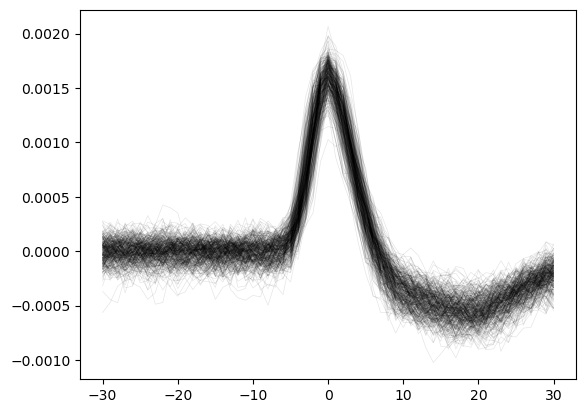

In [12]:
### Plot all spikes on top of each other

import matplotlib.pyplot as plt
window_half_size = 30 #1 ms = 30
for peak_i in range(len(spike_triggers)):
    
    ix = spike_triggers[peak_i]
    window_ixs = np.arange(ix - window_half_size, ix + window_half_size + 1)
    plt.plot(range(-window_half_size,window_half_size+1), spike_data_in_V[window_ixs], lw=0.5, c='k', alpha=0.1)
    
plt.show()

In [6]:
# Open Amplifier file 
from scipy import signal
# (extracellular recording from a silicon polytrode with 32 or 128 electrodes -- frequency band from 0.1 to 7500 Hz)

filename = f"{data_folder}/amplifier2014-11-25T23_00_08.bin"
extra = loadRawData(filename, numChannels = Probe_numChannels, dtype = Probe_dtype) 

extra_Volts = (extra - Probe_y_digitization) * Probe_voltage_step_size

In [15]:
spike_data_in_V.shape, extra_Volts.shape

((16716540,), (32, 16716540))

In [7]:
filtered_data_type = np.float32
num_of_points_in_spike_trig_ivm = 128
num_of_points_for_padding = num_of_points_in_spike_trig_ivm//2

#Filter for extracellular recording
def highpass(data,BUTTER_ORDER=3, F_HIGH=14250,sampleFreq=Sampling_frequency,passFreq=100.0):
    b, a = signal.butter(BUTTER_ORDER,(passFreq/(sampleFreq/2.), F_HIGH/(sampleFreq/2.)),'pass')
    return signal.filtfilt(b,a,data)

shape_spike_data = (num_of_spikes, Probe_numChannels, num_of_points_in_spike_trig_ivm)
ivm_data_filtered = np.zeros(shape_spike_data, dtype=filtered_data_type)
ivm_data_unfiltered = np.zeros(shape_spike_data, dtype=extra_Volts.dtype)

for spike_i in range(num_of_spikes):
    if (spike_i + 1) % 25 == 0:
        print(spike_i +1, end=' ', flush=True)

    trigger_point = spike_triggers[spike_i]
    start_point = int(trigger_point - (num_of_points_in_spike_trig_ivm + num_of_points_for_padding))
    assert start_point >= 0
    end_point = int(trigger_point + (num_of_points_in_spike_trig_ivm + num_of_points_for_padding))
    if end_point > extra.shape[1]:
        break
        
    temp_unfiltered = extra_Volts[:, start_point:end_point].astype(filtered_data_type)
    ivm_data_unfiltered[spike_i] = temp_unfiltered[:, num_of_points_in_spike_trig_ivm:-num_of_points_in_spike_trig_ivm]
    temp_filtered = highpass(temp_unfiltered)
    temp_filtered = temp_filtered[:, num_of_points_in_spike_trig_ivm:-num_of_points_in_spike_trig_ivm]
    ivm_data_filtered[spike_i] = temp_filtered
print()

25 50 75 100 125 150 175 200 225 250 275 300 325 


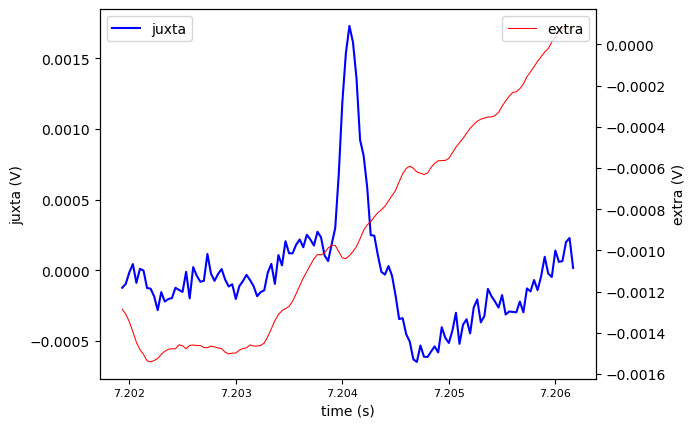

In [12]:
### Plot a single spike -- compare juxta with extracellular recordings for a given channel
import matplotlib.pyplot as plt
spike_i = 3
window_half_size = num_of_points_in_spike_trig_ivm//2 #1 ms = 30
ix = spike_triggers[spike_i]
window_ixs = np.arange(ix - window_half_size, ix + window_half_size + int(window_half_size % 2 == 1))
ax_juxta = plt.subplot(111)
ax_extra = ax_juxta.twinx()
ax_juxta.plot(window_ixs / Sampling_frequency, spike_data_in_V[window_ixs], c='b', label='juxta')

for extra_chan in [Probe_closest_electrode]:#range(Probe_numChannels):
    #ax_extra.plot(window_ixs / Sampling_frequency, extra_Volts[extra_chan,window_ixs], c='r', lw=0.75, label='extra')
    ax_extra.plot(window_ixs / Sampling_frequency, ivm_data_filtered[spike_i,extra_chan], c='r', lw=0.75, label='extra')

ax_juxta.set(xlabel='time (s)', ylabel='juxta (V)')
ax_extra.set(xlabel='time (s)', ylabel='extra (V)')
ax_juxta.tick_params(axis='x',labelsize=8)
ax_juxta.legend(loc='upper left')
ax_extra.legend(loc='upper right')

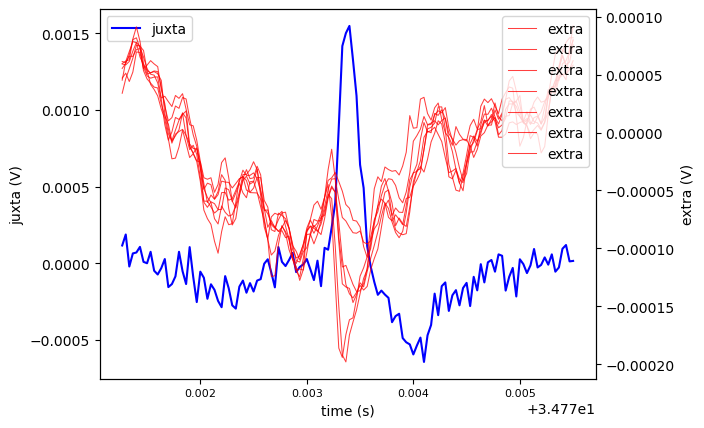

In [18]:
### Plot a single spike -- compare juxta with extracellular recordings for ALL channels surrounding the closest channel

nearby_chans = [23, 8, 18, 28, 9, 3, 13]

import matplotlib.pyplot as plt
spike_i = 11
window_half_size = num_of_points_in_spike_trig_ivm//2 #1 ms = 30
ix = spike_triggers[spike_i]
window_ixs = np.arange(ix - window_half_size, ix + window_half_size + int(window_half_size % 2 == 1))
ax_juxta = plt.subplot(111)
ax_extra = ax_juxta.twinx()
ax_juxta.plot(window_ixs / Sampling_frequency, spike_data_in_V[window_ixs], c='b', label='juxta')

for extra_chan in nearby_chans:
    #ax_extra.plot(window_ixs / Sampling_frequency, extra_Volts[extra_chan,window_ixs], c='r', lw=0.75, label='extra')
    ax_extra.plot(window_ixs / Sampling_frequency, ivm_data_filtered[spike_i,extra_chan], c='r', lw=0.75, alpha=0.75, label='extra')

ax_juxta.set(xlabel='time (s)', ylabel='juxta (V)')
ax_extra.set(xlabel='time (s)', ylabel='extra (V)')
ax_juxta.tick_params(axis='x',labelsize=8)
ax_juxta.legend(loc='upper left')
ax_extra.legend(loc='upper right')

filtered extracellular data


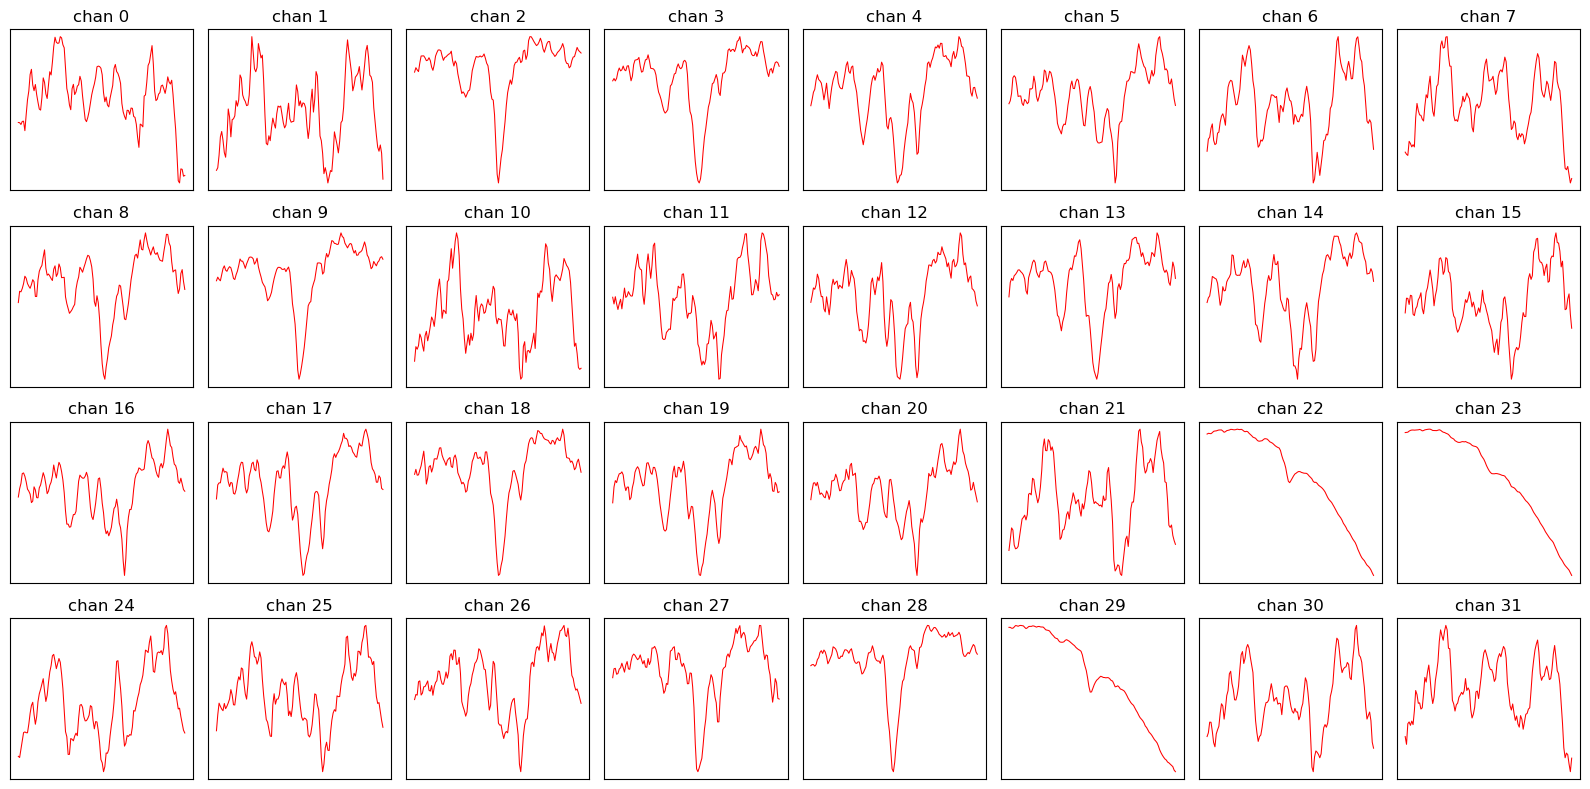

In [15]:
### Plot ALL channels each in a separate subplot within a time window around a juxta spike
## FILTERED DATA

spike_i = 1

ncols = 8
nrows = int(np.ceil(Probe_numChannels/ncols))
f, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))


window_half_size = num_of_points_in_spike_trig_ivm//2 #1 ms = 30
ix = spike_triggers[spike_i]
window_ixs = np.arange(ix - window_half_size, ix + window_half_size +  int(window_half_size % 2 == 1))


for chan_i in range(Probe_numChannels):
    ax = axes.ravel()[chan_i]
    ax.plot(window_ixs / Sampling_frequency, ivm_data_filtered[spike_i,chan_i], c='r', lw=0.75, label='extra')
    ax.set(xticks=[], yticks=[], title=f'chan {chan_i}')
    
f.tight_layout()
print('filtered extracellular data')
plt.show()

unfiltered extracellular data


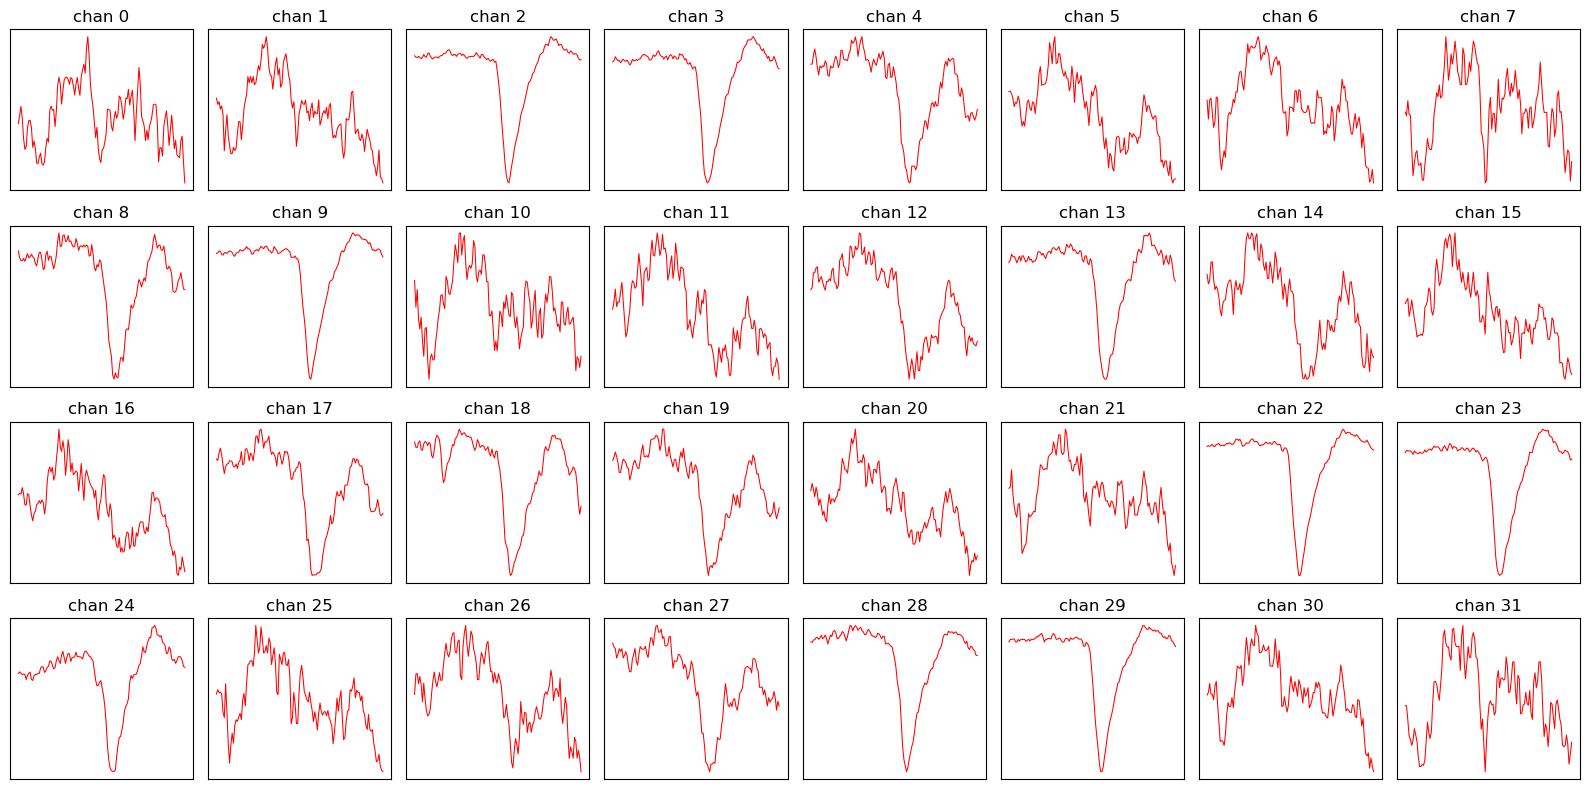

In [18]:
### Plot ALL channels each in a separate subplot within a time window around a juxta spike
## UNFILTERED DATA

spike_i = 2

ncols = 8
nrows = int(np.ceil(Probe_numChannels/ncols))
f, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))

window_half_size = num_of_points_in_spike_trig_ivm//2 #1 ms = 30
ix = spike_triggers[spike_i]
window_ixs = np.arange(ix - window_half_size, ix + window_half_size +  int(window_half_size % 2 == 1))

# # get common y scale for all channels?
# ymin, ymax = extra_Volts[:,window_ixs].min(), extra_Volts[:,window_ixs].max()

for chan_i in range(Probe_numChannels):
    ax = axes.ravel()[chan_i]

    ax.plot(window_ixs / Sampling_frequency, extra_Volts[chan_i,window_ixs], c='r', lw=0.75, label='extra')
    
    ax.set(xticks=[], yticks=[], title=f'chan {chan_i}')
#     ax.set(ylim=(ymin, ymax))
f.tight_layout()
print('unfiltered extracellular data')
plt.show()

unfiltered extracellular data


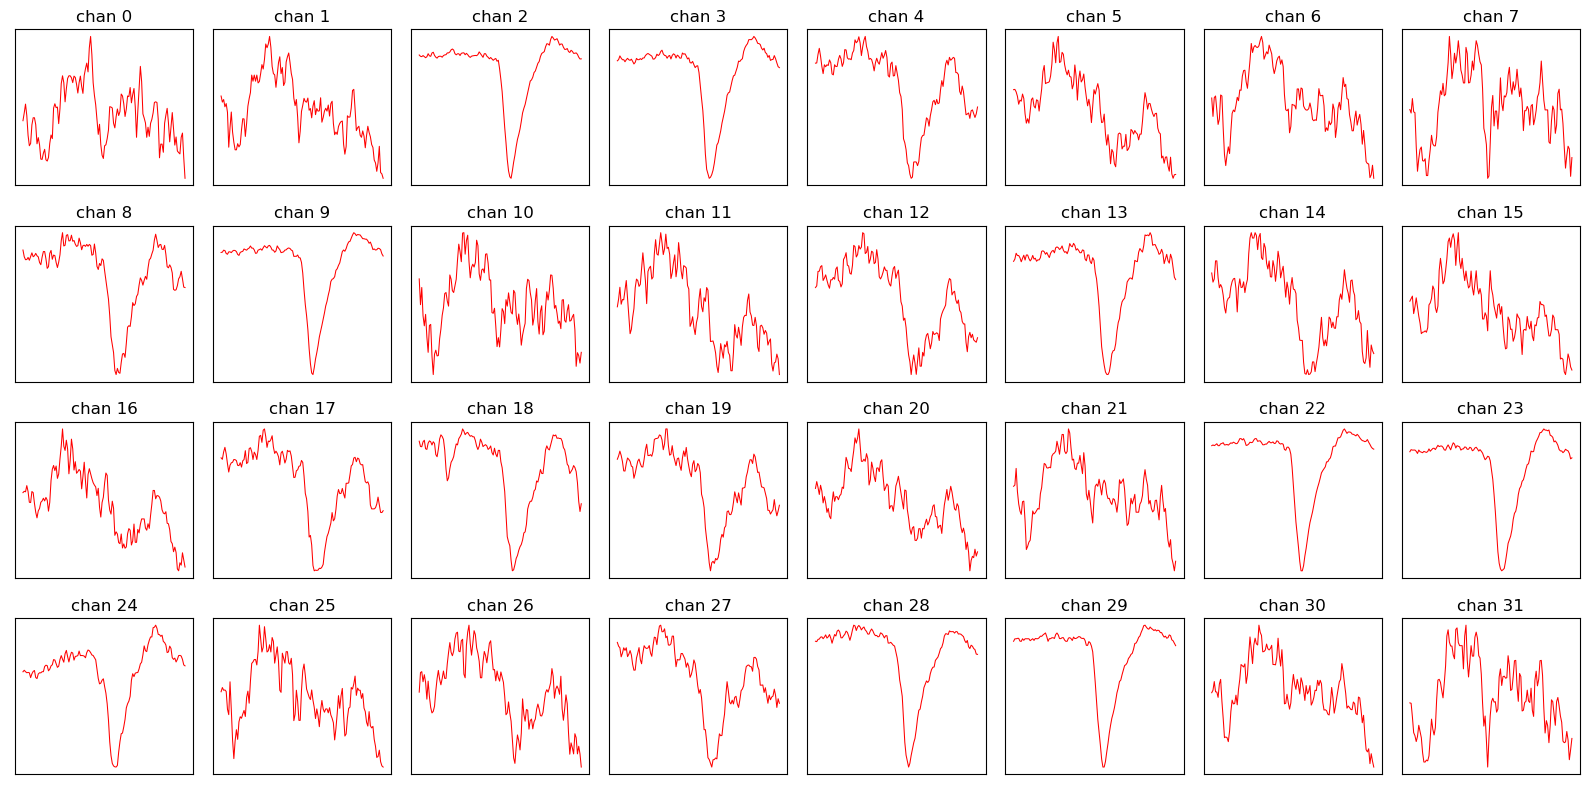

In [97]:
### Plot ALL channels each in a separate subplot within a time window around a juxta spike
## UNFILTERED DATA

spike_i = 2

ncols = 8
nrows = int(np.ceil(Probe_numChannels/ncols))
f, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))

window_half_size = num_of_points_in_spike_trig_ivm//2 #1 ms = 30
ix = spike_triggers[spike_i]
window_ixs = np.arange(ix - window_half_size, ix + window_half_size +  int(window_half_size % 2 == 1))

# # get common y scale for all channels?
# ymin, ymax = extra_Volts[:,window_ixs].min(), extra_Volts[:,window_ixs].max()

for chan_i in range(Probe_numChannels):
    ax = axes.ravel()[chan_i]

    ax.plot(window_ixs / Sampling_frequency, extra_Volts[chan_i,window_ixs], c='r', lw=0.75, label='extra')
    
    ax.set(xticks=[], yticks=[], title=f'chan {chan_i}')
#     ax.set(ylim=(ymin, ymax))
f.tight_layout()
print('unfiltered extracellular data')
plt.show()

unfiltered extracellular data


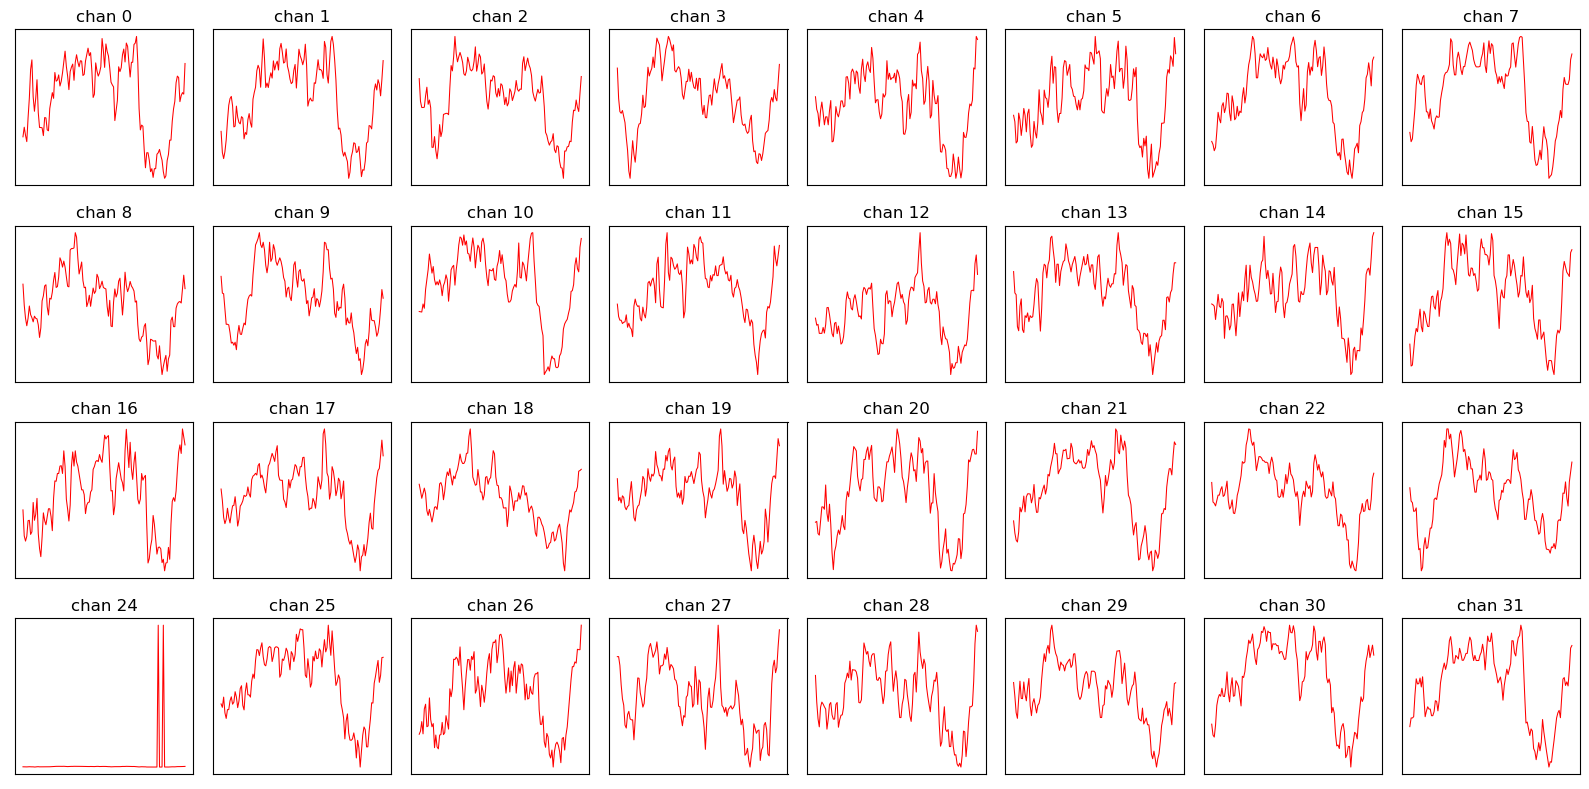

In [80]:
### Plot ALL channels each in a separate subplot within a time window around a juxta spike
## UNFILTERED DATA

spike_i = 0

ncols = 8
nrows = int(np.ceil(Probe_numChannels/ncols))
f, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))

window_half_size = num_of_points_in_spike_trig_ivm//2 #1 ms = 30
ix = spike_triggers[spike_i]
window_ixs = np.arange(ix - window_half_size, ix + window_half_size +  int(window_half_size % 2 == 1))

# # get common y scale for all channels?
# ymin, ymax = extra_Volts[:,window_ixs].min(), extra_Volts[:,window_ixs].max()

for chan_i in range(Probe_numChannels):
    ax = axes.ravel()[chan_i]

    ax.plot(window_ixs / Sampling_frequency, extra_Volts[chan_i,window_ixs], c='r', lw=0.75, label='extra')
    
    ax.set(xticks=[], yticks=[], title=f'chan {chan_i}')
#     ax.set(ylim=(ymin, ymax))
f.tight_layout()
print('unfiltered extracellular data')
plt.show()

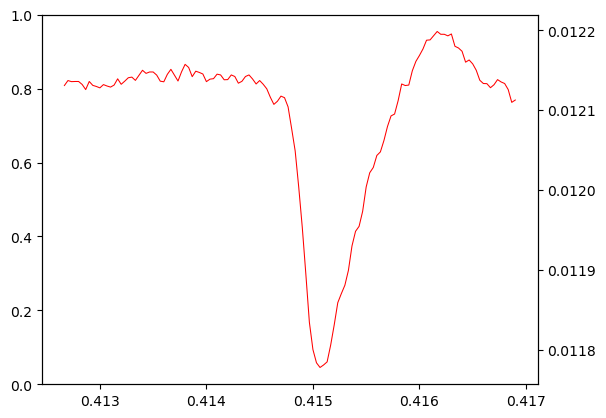

In [83]:
chan_i = 23
spike_i = 2
ax = plt.subplot(111)
#ax.plot(window_ixs / Sampling_frequency, extra_Volts[chan_i,window_ixs], c='r', lw=0.75, label='extra')
ax_ = ax.twinx()
ax_.plot(window_ixs / Sampling_frequency, ivm_data_unfiltered[spike_i,chan_i], c='r', lw=0.75, label='extra')

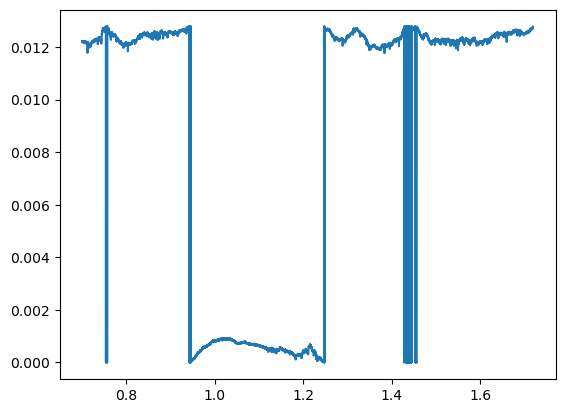

In [28]:
chan = 23
start_t = 0.70
end_t = 1.72
t_ixs = np.arange(round(start_t*Sampling_frequency),round(end_t*Sampling_frequency))
plt.plot(t_ixs/Sampling_frequency, extra_Volts[chan,t_ixs])

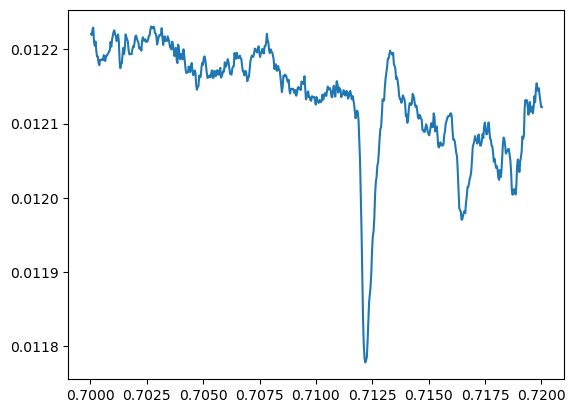

In [20]:
chan = 23
start_t = 0.70
duration_secs = 0.72
t_ixs = np.arange(round(start_t*Sampling_frequency),round(start_t+duration_secs*Sampling_frequency))
plt.plot(start_t/Sampling_frequency + t_ixs/Sampling_frequency, extra_Volts[chan,t_ixs])